In [1]:
BATCH_SIZE = 250
RHO = 0.9
MT = "MT~"
SUB_SAMPLE_SIZE = 1000

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from OverlapIndex import OverlapIndex
from iCONN_index import iCONN
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from artlib import normalize
import pickle

# ── 6) MODEL DEFINITION ───────────────────────────────────────────
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6   = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        z1 = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(z1)))
        x = F.relu(self.bn4(self.conv4(x)))
        z2 = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(z2)))
        x = F.relu(self.bn6(self.conv6(x)))
        z3 = self.pool3(x)

        flat = z3.view(z3.size(0), -1)
        z4 = F.relu(self.fc1(flat))
        out = self.fc2(z4)

        return out, z1, z2, z3, z4

In [5]:

# import torch_directml
# device = torch_directml.device(torch_directml.default_device())

# ── 1) DEVICE SELECTION ───────────────────────────────────────────
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    # device = torch_directml.device(torch_directml.default_device())
print("Using device:", device)

# ── 2) SEED ───────────────────────────────────────────────────────
torch.manual_seed(0)
np.random.seed(0)

# ── 3) DATASETS & DATALOADERS ────────────────────────────────────
transform = transforms.ToTensor()

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False,
                          num_workers=4, pin_memory=False)

# ── 4) LOAD FULL VALIDATION SET ONCE ─────────────────────────────
val_inputs = []
val_labels = []
for xb, yb in val_loader:
    val_inputs.append(xb)
    val_labels.append(yb)
val_inputs = torch.cat(val_inputs, dim=0).to(torch.float32).to(device)  # (10000,1,28,28)
val_labels = torch.cat(val_labels, dim=0).to(torch.long).to(device)     # (10000,)

# ── 5) STRATIFIED SUBSAMPLE FOR OI ───────────────────────────────
y_np = val_labels.cpu().numpy()
sss = StratifiedShuffleSplit(n_splits=1, train_size=SUB_SAMPLE_SIZE, random_state=0)
sub_idx, _ = next(sss.split(np.zeros_like(y_np), y_np))
sub_inputs  = val_inputs[sub_idx]
sub_labels  = val_labels[sub_idx]
y_sub_np    = sub_labels.cpu().numpy()  # for OverlapIndex



model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ── 7) STORAGE ────────────────────────────────────────────────────
oi_conv1 = []
oi_conv2 = []
oi_conv3 = []
oi_fc1   = []

cn_conv1 = []
cn_conv2 = []
cn_conv3 = []
cn_fc1   = []
val_accuracy_history = []

# ── 8) TRAINING LOOP ─────────────────────────────────────────────
model.train()
for epoch in range(1):  # adjust epochs if needed
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (x_batch, y_batch) in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        prev_loss = float("inf")
        for _ in range(10):  # set a max to avoid infinite loops
            model.train()
            out, *_ = model(x_batch)
            loss = criterion(out, y_batch)
    
            # Check convergence
            if abs(prev_loss - loss.item()) < 1e-4:
                break
            prev_loss = loss.item()
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # --- validation accuracy (every batch) ---
        model.eval()
        with torch.no_grad():
            logits_val, _, _, _, _ = model(val_inputs)
            preds = logits_val.argmax(dim=1)
            val_acc = (preds == val_labels).float().mean().item()
            val_accuracy_history.append(val_acc)

            # --- only every 5 batches: compute OI on subsample ---
            if batch_idx % 5 == 0:
                _, z1_sub, z2_sub, z3_sub, z4_sub = model(sub_inputs)
                X1 = z1_sub.view(z1_sub.size(0), -1).cpu().numpy()
                X2 = z2_sub.view(z2_sub.size(0), -1).cpu().numpy()
                X3 = z3_sub.view(z3_sub.size(0), -1).cpu().numpy()
                X4 = z4_sub.view(z4_sub.size(0), -1).cpu().numpy()
                
                oi1 = OverlapIndex(rho=RHO, ART="Fuzzy", match_tracking=MT)
                oi2 = OverlapIndex(rho=RHO, ART="Fuzzy", match_tracking=MT)
                oi3 = OverlapIndex(rho=RHO, ART="Fuzzy", match_tracking=MT)
                oi4 = OverlapIndex(rho=RHO, ART="Fuzzy", match_tracking=MT)

                cn1 = iCONN(rho=RHO, match_tracking=MT)
                cn2 = iCONN(rho=RHO, match_tracking=MT)
                cn3 = iCONN(rho=RHO, match_tracking=MT)
                cn4 = iCONN(rho=RHO, match_tracking=MT)

                # prepare once per OI instance
                X1_p, _, _ = normalize(X1)
                X2_p, _, _ = normalize(X2)
                X3_p, _, _ = normalize(X3)
                X4_p, _, _ = normalize(X4)

                oi_conv1.append(oi1.add_batch(X1_p, y_sub_np))
                oi_conv2.append(oi2.add_batch(X2_p, y_sub_np))
                oi_conv3.append(oi3.add_batch(X3_p, y_sub_np))
                oi_fc1.append(  oi4.add_batch(X4_p, y_sub_np))

                cn_conv1.append(cn1.add_batch(X1_p, y_sub_np))
                cn_conv2.append(cn2.add_batch(X2_p, y_sub_np))
                cn_conv3.append(cn3.add_batch(X3_p, y_sub_np))
                cn_fc1.append(  cn4.add_batch(X4_p, y_sub_np))

        model.train()
        loop.set_postfix(loss=loss.item(), val_acc=val_acc)
        
# ── 9) RAW VALIDATION OI ──────────────────────────────────────────
X_raw = sub_inputs.view(sub_inputs.size(0), -1).cpu().numpy()
oi_raw = OverlapIndex(rho=RHO, ART="Fuzzy", match_tracking=MT)
cn_raw = iCONN(rho=RHO, match_tracking=MT)
X_prep, _, _ = normalize(X_raw)
oi_val_raw = oi_raw.add_batch(X_prep, y_sub_np)
cn_val_raw = cn_raw.add_batch(X_prep, y_sub_np)

print("Done.")
print(f"Total batches:        {len(train_loader)}")
print(f"OI computed batches:  {len(oi_conv1)}  (≈ every 5th batch)")
print(f"Raw-val OI:           {oi_val_raw:.4f}")
print(f"Raw-val CONN:           {cn_val_raw:.4f}")

pickle.dump(
    {"oi_conv1_pooled": oi_conv1, "oi_conv2_pooled":oi_conv2, "oi_conv3_pooled":oi_conv3, "oi_fc1":oi_fc1, "oi_raw": oi_val_raw, 
     "cn_conv1_pooled": cn_conv1, "cn_conv2_pooled":cn_conv2, "cn_conv3_pooled":cn_conv3, "cn_fc1":cn_fc1, "cn_raw": cn_val_raw,
     "val_accuracy_history":val_accuracy_history}, 
    open("cifar_oi_tilda.pickle", "wb")
)

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Done.
Total batches:        200
OI computed batches:  40  (≈ every 5th batch)
Raw-val OI:           0.3610
Raw-val CONN:           0.0000


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from artlib import normalize
import pickle
# import torch_directml
# device = torch_directml.device(torch_directml.default_device())

# ── 1) DEVICE SELECTION ───────────────────────────────────────────
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    # device = torch_directml.device(torch_directml.default_device())
print("Using device:", device)

# ── 2) SEED ───────────────────────────────────────────────────────
torch.manual_seed(0)
np.random.seed(0)

# ── 3) DATASETS & DATALOADERS ────────────────────────────────────
transform = transforms.ToTensor()
train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=1024, shuffle=False,
                          num_workers=4, pin_memory=False)

# ── 4) LOAD FULL VALIDATION SET ONCE ─────────────────────────────
val_inputs = []
val_labels = []
for xb, yb in val_loader:
    val_inputs.append(xb)
    val_labels.append(yb)
val_inputs = torch.cat(val_inputs, dim=0).to(torch.float32).to(device)  # (10000,1,28,28)
val_labels = torch.cat(val_labels, dim=0).to(torch.long).to(device)     # (10000,)

# ── 5) STRATIFIED SUBSAMPLE FOR OI ───────────────────────────────
y_np = val_labels.cpu().numpy()
sss = StratifiedShuffleSplit(n_splits=1, train_size=SUB_SAMPLE_SIZE, random_state=0)
sub_idx, _ = next(sss.split(np.zeros_like(y_np), y_np))
sub_inputs  = val_inputs[sub_idx]
sub_labels  = val_labels[sub_idx]
y_sub_np    = sub_labels.cpu().numpy()  # for OverlapIndex


model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ── 7) STORAGE ────────────────────────────────────────────────────
sil_conv1 = []
sil_conv2 = []
sil_conv3 = []
sil_fc1   = []

val_accuracy_history = []

# ── 8) TRAINING LOOP ─────────────────────────────────────────────
model.train()
for epoch in range(1):  # adjust epochs if needed
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (x_batch, y_batch) in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # --- training step ---
        optimizer.zero_grad()
        logits, _, _, _, _ = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        # --- validation accuracy (every batch) ---
        model.eval()
        with torch.no_grad():
            logits_val, _, _, _, _ = model(val_inputs)
            preds = logits_val.argmax(dim=1)
            val_acc = (preds == val_labels).float().mean().item()
            val_accuracy_history.append(val_acc)

            # --- only every 5 batches: compute OI on subsample ---
            if batch_idx % 5 == 0:
                _, z1_sub, z2_sub, z3_sub, z4_sub = model(sub_inputs)
                X1 = z1_sub.view(z1_sub.size(0), -1).cpu().numpy()
                X2 = z2_sub.view(z2_sub.size(0), -1).cpu().numpy()
                X3 = z3_sub.view(z3_sub.size(0), -1).cpu().numpy()
                X4 = z4_sub.view(z4_sub.size(0), -1).cpu().numpy()
            
                y_np_sub = y_sub_np
            
                # Compute silhouette scores
                try:
                    score1 = silhouette_score(X1, y_np_sub)
                except:
                    score1 = np.nan
            
                try:
                    score2 = silhouette_score(X2, y_np_sub)
                except:
                    score2 = np.nan
            
                try:
                    score3 = silhouette_score(X3, y_np_sub)
                except:
                    score3 = np.nan

                try:
                    score4 = silhouette_score(X4, y_np_sub)
                except:
                    score4 = np.nan
            
                sil_conv1.append(score1)
                sil_conv2.append(score2)
                sil_conv3.append(score3)
                sil_fc1.append(score4)


        model.train()
        loop.set_postfix(loss=loss.item(), val_acc=val_acc)
        
# ── 9) RAW VALIDATION OI ──────────────────────────────────────────
X_raw = sub_inputs.view(sub_inputs.size(0), -1).cpu().numpy()
try:
    silhouette_raw = silhouette_score(X_raw, y_sub_np)
except:
    silhouette_raw = np.nan


print("Done.")
print(f"Total batches:        {len(train_loader)}")
print(f"OI computed batches:  {len(sil_conv1)}  (≈ every 5th batch)")
print(f"Raw-val Silhouette:   {silhouette_raw:.4f}")


pickle.dump(
    {"sil_conv1_pooled": sil_conv1, "sil_conv2_pooled":sil_conv2, "sil_conv3_pooled":sil_conv3, "sil_fc1":sil_fc1, "sil_raw": silhouette_raw, 
     "val_accuracy_history":val_accuracy_history}, 
    open("cifar_sil.pickle", "wb")
)

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Done.
Total batches:        200
OI computed batches:  40  (≈ every 5th batch)
Raw-val Silhouette:   -0.0634


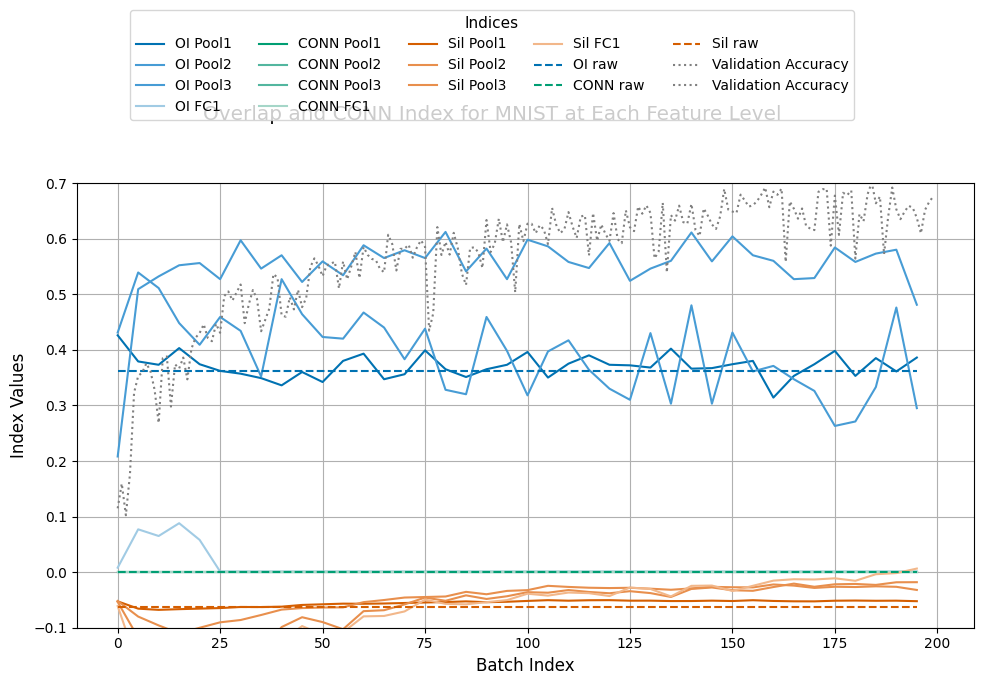

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11
})

# Load data
data = pickle.load(open("cifar_oi_tilda.pickle", "rb"))
oi_conv1 = data["oi_conv1_pooled"]
cn_conv1 = data["cn_conv1_pooled"]
oi_conv2 = data["oi_conv2_pooled"]
cn_conv2 = data["cn_conv2_pooled"]
oi_conv3 = data["oi_conv3_pooled"]
cn_conv3 = data["cn_conv3_pooled"]
oi_fc1 = data["oi_fc1"]
cn_fc1 = data["cn_fc1"]
oi_val_raw = data["oi_raw"]
cn_val_raw = data["cn_raw"]
val_accuracy_history = data["val_accuracy_history"]

data_sil = pickle.load(open("cifar_sil.pickle", "rb"))
sil_conv1 = data_sil["sil_conv1_pooled"]
sil_conv2 = data_sil["sil_conv2_pooled"]
sil_conv3 = data_sil["sil_conv3_pooled"]
sil_fc1 = data_sil["sil_fc1"]
sil_val_raw = data_sil["sil_raw"]

batches_oi = 5 * np.arange(len(oi_conv1))
batches_acc = np.arange(len(val_accuracy_history))

# Create single-axis plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot index curves
ax.plot(batches_oi, oi_conv1, label='OI Pool1', color='#0072B2')
ax.plot(batches_oi, oi_conv2, label='OI Pool2', color='#479CD5')
ax.plot(batches_oi, oi_conv3, label='OI Pool3', color='#479CD5')
ax.plot(batches_oi, oi_fc1,  label='OI FC1',   color='#A1CBE4')

ax.plot(batches_oi, cn_conv1, label='CONN Pool1', color='#009E73')
ax.plot(batches_oi, cn_conv2, label='CONN Pool2', color='#53B69F')
ax.plot(batches_oi, cn_conv3, label='CONN Pool3', color='#53B69F')
ax.plot(batches_oi, cn_fc1,  label='CONN FC1',   color='#A5D6C8')

ax.plot(batches_oi, sil_conv1, label='Sil Pool1', color='#D55E00')
ax.plot(batches_oi, sil_conv2, label='Sil Pool2', color='#E88F4D')
ax.plot(batches_oi, sil_conv3, label='Sil Pool3', color='#E88F4D')
ax.plot(batches_oi, sil_fc1,  label='Sil FC1',   color='#F2B78A')

# Plot raw data as horizontal lines
ax.hlines(oi_val_raw, xmin=batches_oi[0], xmax=batches_oi[-1], linestyle='--', label='OI raw', color='#0072B2')
ax.hlines(cn_val_raw, xmin=batches_oi[0], xmax=batches_oi[-1], linestyle='--', label='CONN raw', color='#009E73')
ax.hlines(sil_val_raw, xmin=batches_oi[0], xmax=batches_oi[-1], linestyle='--', label='Sil raw', color='#D55E00')

# Secondary axis for validation accuracy
ax.plot(batches_acc, val_accuracy_history, color='gray', linestyle=':', label='Validation Accuracy', alpha=1.0)
ax.set_ylabel("Validation Accuracy")
ax.set_ylim(-0.1, 0.7)

# Labels and titles
ax.set_xlabel("Batch Index")
ax.set_ylabel("Index Values")
fig.suptitle('Overlap and CONN Index for MNIST at Each Feature Level')

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, title='Indices')

# Layout
ax.grid(True)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # for legend
plt.savefig("figures/mnist_oi_accuracy_single_plot.png", bbox_inches='tight')
plt.show()


In [14]:
val_accuracy_history[-1]

0.6757000088691711

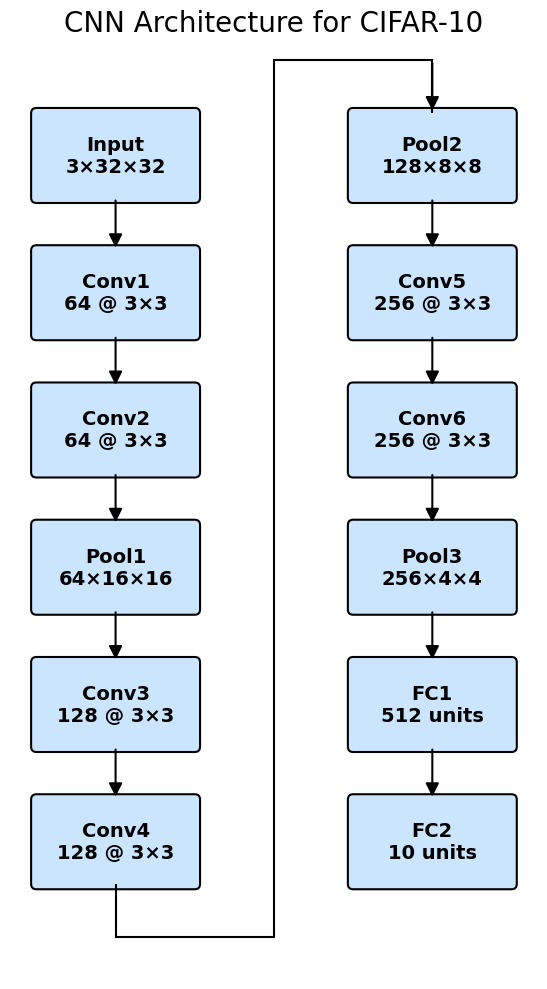

In [44]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, PathPatch
from matplotlib.path import Path

# Define layers
layers = [
    ("Input\n3×32×32", "#cce5ff"),
    ("Conv1\n64 @ 3×3", "#cce5ff"),
    ("Conv2\n64 @ 3×3", "#cce5ff"),
    ("Pool1\n64×16×16", "#cce5ff"),
    ("Conv3\n128 @ 3×3", "#cce5ff"),
    ("Conv4\n128 @ 3×3", "#cce5ff"),
    ("Pool2\n128×8×8", "#cce5ff"),
    ("Conv5\n256 @ 3×3", "#cce5ff"),
    ("Conv6\n256 @ 3×3", "#cce5ff"),
    ("Pool3\n256×4×4", "#cce5ff"),
    ("FC1\n512 units", "#cce5ff"),
    ("FC2\n10 units", "#cce5ff"),
]

# Split into two columns
split_index = len(layers) // 2
left_layers = layers[:split_index]
right_layers = layers[split_index:]

# Layout parameters
box_width = 1.5
box_height = 0.8
v_spacing = 1.3
x_left = -1.5
x_right = 1.5

# Compute positions
positions = {}
for i, (label, _) in enumerate(left_layers):
    positions[label] = (x_left, -i * v_spacing)
for i, (label, _) in enumerate(right_layers):
    positions[label] = (x_right, -i * v_spacing)

# Create figure
fig, ax = plt.subplots(figsize=(7, 10))

# Draw boxes
for label, color in layers:
    x, y = positions[label]
    rect = FancyBboxPatch(
        (x - box_width / 2, y - box_height / 2),
        box_width, box_height,
        boxstyle="round,pad=0.05",
        edgecolor="black",
        facecolor=color,
        linewidth=1.5
    )
    ax.add_patch(rect)
    ax.text(x, y, label, ha='center', va='center', fontsize=14, weight='bold')

# Draw arrows in left column
for i in range(len(left_layers) - 1):
    label_from, _ = left_layers[i]
    label_to, _ = left_layers[i + 1]
    x0, y0 = positions[label_from]
    x1, y1 = positions[label_to]
    arrow = FancyArrowPatch(
        (x0, y0 - box_height / 2),
        (x1, y1 + box_height / 2),
        arrowstyle='-|>',
        mutation_scale=20,
        linewidth=1.5,
        color='black'
    )
    ax.add_patch(arrow)

# Draw arrows in right column
for i in range(len(right_layers) - 1):
    label_from, _ = right_layers[i]
    label_to, _ = right_layers[i + 1]
    x0, y0 = positions[label_from]
    x1, y1 = positions[label_to]
    arrow = FancyArrowPatch(
        (x0, y0 - box_height / 2),
        (x1, y1 + box_height / 2),
        arrowstyle='-|>',
        mutation_scale=20,
        linewidth=1.5,
        color='black'
    )
    ax.add_patch(arrow)

# Add S-shaped arrow from bottom of left to top of right
x0, y0 = positions[left_layers[-1][0]]
x2, y2 = positions[right_layers[0][0]]
x1 = (x0+x2)/2
y0 -= box_height / 2
y2 += box_height / 2

# Path points: down → right → up → left
z = v_spacing-box_height
verts = [
    (x0, y0),              # start
    (x0, y0 - z),        # down
    (x1, y0 - z),        # right
    (x1, y2 + z),        # up
    (x2, y2 + z),        # right
    (x2, y2)               # end
]
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO
]

# Line path
path = Path(verts, codes)
path_patch = PathPatch(path, edgecolor='black', linewidth=1.5, fill=False)
ax.add_patch(path_patch)

# Arrowhead
arrow_head = FancyArrowPatch(
    posA=verts[-2],
    posB=verts[-1],
    arrowstyle='-|>',
    mutation_scale=20,
    color='black',
    linewidth=1.5
)
ax.add_patch(arrow_head)

# Final styling
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-len(left_layers)*v_spacing, 1.1)
ax.set_aspect('equal')
ax.axis('off')
plt.title("CNN Architecture for CIFAR-10", fontsize=20)
plt.tight_layout()
fig.savefig("figures/cnn_arch_cifar.png", bbox_inches='tight')
plt.show()
